# 2-Cell and 3-Cell Motifs in PyC Subgraph

### Downloading data
Uncomment and run the cell below if you'd like to run the cells below

In [1]:
#! bash downloadData.sh

In [2]:
import os
import random
from time import time
import pandas as pd
import numpy as np
import networkx as nx

from utils.graph_creation import *
from utils.motif_counts import *
from utils.visualization import *
from utils.fileio import *

## Create PyC Subgraph

In [3]:
# fetch and preview the synapses table
pcy_synapses = read_pyc_graph("data/pyc_graph_v185.csv")
pcy_synapses.head()

,segmentation,id,valid,pre_pt_position,pre_pt_supervoxel_id,pre_pt_root_id,ctr_pt_position,post_pt_position,post_pt_supervoxel_id,post_pt_root_id,size,spine_vol,exclude_conn
0,185,1484,1,"[91332, 57836, 1584]",97170491155950710,648518346349539437,"[91369, 57798, 1582]","[91332, 57748, 1584]",97170491155951077,648518346349531254,798,0.133004,0
1,185,2254,1,"[64762, 45414, 711]",89838917557174822,648518346349537978,"[64742, 45419, 708]","[64720, 45430, 708]",89838917557173796,648518346349537300,129,0.016346,0
2,185,3785,1,"[69646, 63086, 721]",91264984138384361,648518346349533058,"[69604, 63106, 721]","[69558, 63120, 721]",90983509161691227,648518346349538715,62,0.020969,0
3,185,3863,1,"[66776, 39946, 1138]",90396382837344883,648518346349539333,"[66750, 39982, 1139]","[66722, 39990, 1139]",90396382837366381,648518346349539806,62,0.018033,0
4,185,4062,1,"[89112, 48970, 2154]",96597662777759466,648518346349523975,"[89162, 48958, 2154]","[89198, 48936, 2154]",96597662777759456,648518346349537716,62,0.008805,0


In [4]:
pcy_synapses = format_synapses(pcy_synapses)

# create the simple directed graph (no self-loops, no multi-edges)
# treat multiple synapses as one connection
pyc_subgraph = synapses_to_connections(pcy_synapses[['pre','post']])
# remove self-loops
g_actual = remove_autapses(edges_to_graph(pyc_subgraph))

In [5]:
print(nx.info(g_actual))

Name: 
Type: DiGraph
Number of nodes: 334
Number of edges: 1738
Average in degree:   5.2036
Average out degree:   5.2036


## 2-Cell Motifs

In [6]:
%%time
# count 2-cell motifs in the observation
obs_two_counts = count_two_neuron_motifs_graph(g_actual)
# analytically compute 2-cell motif counts in Erdos-Renyi model
er_two_counts = compute_ER_two_neuron_motifs(g_actual)

CPU times: user 12 ms, sys: 0 ns, total: 12 ms
Wall time: 10.1 ms


In [7]:
%%time
s=100 # total 1000 samples (10 workers x 100 continous samples)
config_two_counts = sample_motifs_parallel_continuous(continuous_sample_two_neuron_motifs, g_actual, samples=s, niters=int(1e4), threads=10)

CPU times: user 156 ms, sys: 44 ms, total: 200 ms
Wall time: 1min 10s


connect probability =  0.015626404847961736


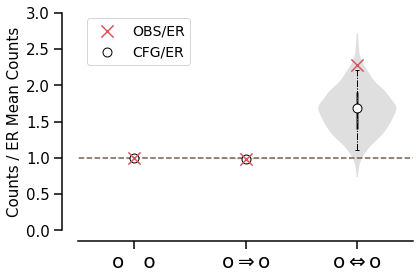

In [8]:
# relative counts in ratio (/ER expected counts)
res_two = plot_two_neuron_counts_violin(obs_two_counts, er_two_counts, config_two_counts, ylim=(0, 3), fname="2_violin");

In [9]:
res_two

,obs,er_exp,config_exp,config_std,config_z
actual_edges,NaN,NaN,1738.000,0.000000,NaN
autapses,NaN,NaN,0.000,0.000000,NaN
bi,31.0,13.579346,22.546,4.361526,1.938313
neurons,NaN,NaN,334.000,0.000000,NaN
null,53904.0,53886.579346,53895.546,4.361526,1.938313
potential_edges,NaN,NaN,111222.000,0.000000,NaN
uni,1676.0,1710.841308,1692.908,8.723052,-1.938313


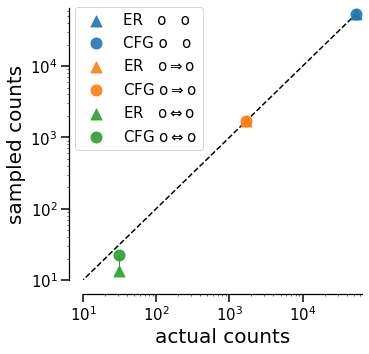

In [10]:
plot_two_neuron_counts_scatter(obs_two_counts, er_two_counts, config_two_counts, figsize=(5,5), fname="2_scatter")

In [11]:
# p-values
np.minimum((config_two_counts > obs_two_counts).sum(0) / 1000, 
           (config_two_counts < obs_two_counts).sum(0) / 1000)

neurons            0.000
autapses           0.000
actual_edges       0.000
uni                0.023
bi                 0.023
potential_edges    0.000
null               0.023
dtype: float64

## 3-Cell Motifs

In [12]:
%%time
# count 3-cell motifs in the observation
obs_three_counts, _ = count_three_neuron_motifs(*graph_to_sets(g_actual), motifs)
# analytically compute 2-cell motif counts in Erdos-Renyi model
three_pr, two_pr = compute_three_neuron_motif_probabilities(g_actual)
er_three_counts = compute_expected_three_neuron_motifs(g_actual, three_pr)

CPU times: user 2min 8s, sys: 144 ms, total: 2min 8s
Wall time: 2min 8s


In [ ]:
%%time
s=100 # total 1000 samples (10 workers x 100 continous samples)
config_three_counts = sample_motifs_parallel_continuous(continuous_sample_three_neuron_motifs, g_actual, samples=s, niters=int(1e4), threads=10)

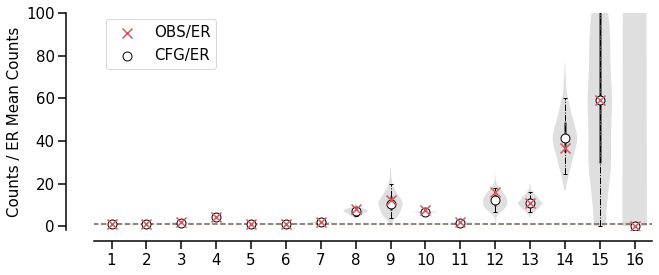

In [23]:
# relative counts in ratio (/ER expected counts)
res_three = plot_three_neuron_counts_violin(obs_three_counts, er_three_counts, config_three_counts, 
                                            subtitle='', ylim=[-2, 100], fname="3_violin", figsize=(10,4))

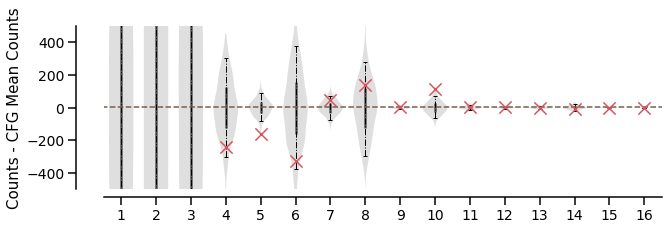

In [24]:
# relative counts in difference (-CFG expected counts)
plot_three_neuron_counts_diff_violin(obs_three_counts, er_three_counts, config_three_counts, 
                                     subtitle='', ylim=[-500, 500], fname="3_violin_diff");

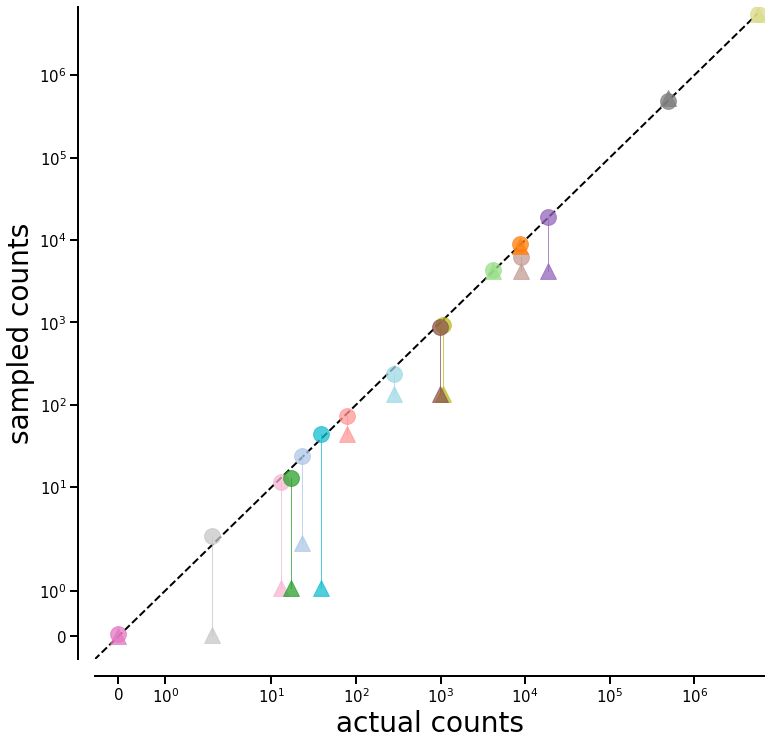

In [25]:
plot_three_neuron_counts_scatter(obs_three_counts, er_three_counts, config_three_counts, figsize=(12,12), fname="3_scatter")

In [26]:
res_three

,obs,er_exp,config_exp,config_std,config_z
1,5622854,5.599346e+06,5620426.328,1164.470897,2.084785
2,488467,5.333197e+05,493024.243,2128.015474,-2.141546
3,8828,4.233083e+03,6270.948,1174.153003,2.177784
4,18644,4.233083e+03,18885.817,181.661400,-1.331141
5,4209,4.233083e+03,4368.183,51.747844,-3.076128
6,8755,8.466165e+03,9081.518,227.594308,-1.434649
7,284,1.343959e+02,238.759,44.562930,1.015216
8,1071,1.343959e+02,933.204,175.674010,0.784385
9,13,1.066731e+00,11.489,5.181189,0.291632
10,999,1.343959e+02,887.342,41.436216,2.694696


In [27]:
# p-values
np.minimum((config_three_counts > obs_three_counts).sum(0) / 1000, 
           (config_three_counts < obs_three_counts).sum(0) / 1000)

1     0.017
2     0.016
3     0.013
4     0.088
5     0.002
6     0.070
7     0.167
8     0.221
9     0.322
10    0.004
11    0.224
12    0.126
13    0.434
14    0.301
15    0.323
16    0.000
dtype: float64

## Clustering Coefficient

In [28]:
# clustering coefficient of the observed network
nx.transitivity(g_actual.to_undirected())

0.09538309604147807

In [29]:
# expected clustering coefficient of the networsk sampled from the  ER model
1-two_pr['pr_null']

0.031008625167451065

In [30]:
# expected clustering coefficient of the networsk sampled from the CFG model
clustering_coef(config_three_counts).mean()

0.08541348334612711